In [19]:
%matplotlib inline

Model Overview
------------------------------------------
GCN from the perspective of message passing
```````````````````````````````````````````````
We describe a layer of graph convolutional neural network from a message
passing perspective; the math can be found `here <math_>`_.
It boils down to the following step, for each node $u$:

1) Aggregate neighbors' representations $h_{v}$ to produce an
intermediate representation $\hat{h}_u$.  2) Transform the aggregated
representation $\hat{h}_{u}$ with a linear projection followed by a
non-linearity: $h_{u} = f(W_{u} \hat{h}_u)$.

We will implement step 1 with DGL message passing, and step 2 with the
``apply_nodes`` method, whose node UDF will be a PyTorch ``nn.Module``.

GCN implementation with DGL
``````````````````````````````````````````
We first define the message and reduce function as usual.  Since the
aggregation on a node $u$ only involves summing over the neighbors'
representations $h_v$, we can simply use builtin functions:



We then define the node UDF for ``apply_nodes``, which is a fully-connected layer:



In [21]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
#message passing and reduce functions
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

class NodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(gcn_msg, gcn_reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.gcn1 = GCN(2, 8, F.relu)
        self.gcn2 = GCN(8, 2, F.relu)
    
    def forward(self, g, features):
        x = self.gcn1(g, features)
        x = self.gcn2(g, x)
        return x
net = Net()

We then proceed to define the GCN module. A GCN layer essentially performs
message passing on all the nodes then applies the `NodeApplyModule`. Note
that we omitted the dropout in the paper for simplicity.



The forward function is essentially the same as any other commonly seen NNs
model in PyTorch.  We can initialize GCN like any ``nn.Module``. For example,
let's define a simple neural network consisting of two GCN layers. Suppose we
are training the classifier for the cora dataset (the input feature size is
1433 and the number of classes is 7).



Net(
  (gcn1): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=2, out_features=8, bias=True)
    )
  )
  (gcn2): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=8, out_features=2, bias=True)
    )
  )
)


We load the cora dataset using DGL's built-in data module.



In [24]:
import matplotlib.pyplot as plt
def plot_my_graph(g):
    fig, ax = plt.subplots()
    nx.draw(g.to_networkx(),ax=ax)

import torch
import networkx as nx
def load_my_own_data():
    g = dgl.DGLGraph()
    g.add_nodes(12)
    g1 = dgl.DGLGraph()
    g1.add_nodes(12)
    #change this clean it and document.
    features = th.FloatTensor([[0,1,0,1,0,1,0,1,0,1,1,0],[1,0,1,0,1,0,1,0,0,0,0,0]])
    features = torch.reshape(features,(12,2))
    labels = th.LongTensor([0,0,0,0,0,1,1,1,1,1,0,0])
    g.add_edges(0,[1,2,3,4,5,6,7,8,9,10,11])
    g.add_edges(1,2)
    g.add_edges(2,1)
    g.add_edges(1,3)
    g.add_edges(1,3)
    g.add_edges(2,3)
    g.add_edges(3,4)
    g.add_edges(4,5)
    g.add_edges(5,6)
    g.add_edges(6,5)
    g.add_edges(5,7)
    g.add_edges(7,5)
    g.add_edges(7,6)
    g.add_edges(6,7)
    g1.add_edges(0,[0,1,2,3,4,5,6,7,8,9,10,11])
    g1.add_edges(1,2)
    g1.add_edges(2,1)
    g1.add_edges(1,3)
    g1.add_edges(2,3)
    g1.add_edges(2,4)
    g1.add_edges(4,2)
    g1.add_edges(3,4)
    g1.add_edges(4,5)
    g1.add_edges(5,6)
    g1.add_edges(6,5)
    g1.add_edges(5,7)
    g1.add_edges(7,5)
    g1.add_edges(7,6)
    g1.add_edges(6,7)
    g1.add_edges(8,9)
    g1.add_edges(9,8)
    labels2 = th.LongTensor([1,0,0,0,1,1,1,1,1,1,0,0])
    features2 = th.FloatTensor([[1,0,0,1,0,1,0,1,1,1,1,0],[1,0,1,0,1,0,1,0,0,0,0,0]])
    features2 = torch.reshape(features2,(12,2))
    #creating mask for generating the cross_entropy loss / nll_loss
    mask = torch.ByteTensor([1,1,1,1,1,1,1,1,1,1,1,1])
    print(mask)    
    return g, features, labels, mask, g1, features2, labels2

We then train the network as follows:



tensor([0., 1.])
tensor([0., 1.])
torch.Size([2, 12])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.uint8)
tensor([0., 1.])
tensor([0., 1.])
torch.Size([2, 12])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.uint8)


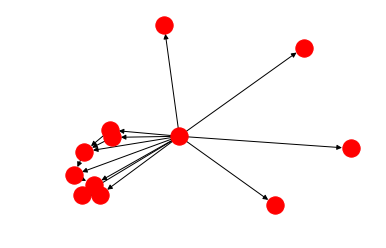

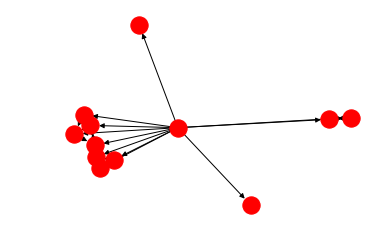

In [25]:
load_my_own_data()
g, features, labels, mask, g1, feature2, labels2 = load_my_own_data()
plot_my_graph(g)
plot_my_graph(g1)

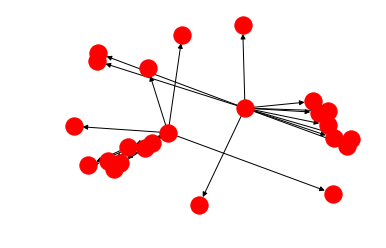

In [26]:
import dgl
bg = dgl.batch([g,g1])
plot_my_graph(bg)

torch.Size([2, 12])
Printing features
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.]])
tensor([0., 1.])
tensor([0., 1.])
torch.Size([2, 12])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.uint8)
Printing features
torch.Size([12, 2])
Epoch 00000 | Loss 0.7362 | Time(s) nan
Epoch 00001 | Loss 0.7340 | Time(s) nan
Epoch 00002 | Loss 0.7318 | Time(s) nan
Epoch 00003 | Loss 0.7296 | Time(s) 0.0034
Epoch 00004 | Loss 0.7275 | Time(s) 0.0031
Epoch 00005 | Loss 0.7254 | Time(s) 0.0029
Epoch 00006 | Loss 0.7232 | Time(s) 0.0027
Epoch 00007 | Loss 0.7211 | Time(s) 0.0028
Epoch 00008 | Loss 0.7191 | Time(s) 0.0028
Epoch 00009 | Loss 0.7170 | Time(s) 0.0027
Epoch 00010 | Loss 0.7150 | Time(s) 0.0028
Epoch 00011 | Loss 0.7130 | Time(s) 0.0028
Epoch 00012 | Loss 0.7110 | Time(s) 0.0027
Epoch 00013 | Loss 0.7090 | Time(s) 0.0

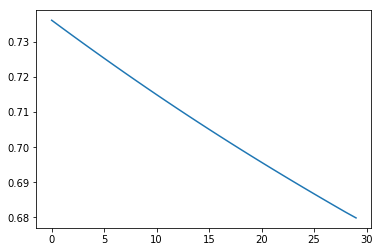

tensor([[-0.6810, -0.7055],
        [-0.6513, -0.7369],
        [-0.5884, -0.8102],
        [-0.6170, -0.7756],
        [-0.5937, -0.8036],
        [-0.4152, -1.0794],
        [-0.5750, -0.8271],
        [-0.5750, -0.8271],
        [-0.5594, -0.8475],
        [-0.5594, -0.8475],
        [-0.6810, -0.7055],
        [-0.6810, -0.7055]], grad_fn=<LogSoftmaxBackward>)
tensor([[0.1970, 0.1725],
        [0.2333, 0.1477],
        [0.5929, 0.3710],
        [0.4762, 0.3176],
        [0.3863, 0.1763],
        [0.6642, 0.0000],
        [0.2521, 0.0000],
        [0.2521, 0.0000],
        [0.3980, 0.1099],
        [0.3980, 0.1099],
        [0.1970, 0.1725],
        [0.1970, 0.1725]], grad_fn=<ReluBackward0>)
tensor(0.7630, grad_fn=<NllLossBackward>)
DGLGraph(num_nodes=12, num_edges=23,
         ndata_schemes={}
         edata_schemes={})


In [53]:
import time
import numpy as np
import matplotlib.pyplot as plt

g, features, labels, mask, g1, feature2, labels2 = load_my_own_data()
optimizer = th.optim.Adam(net.parameters(), lr=1e-3)
dur = []
epoch_loss = 0
epoch_losses = []
for epoch in range(30):
    if epoch >=3:
        t0 = time.time()
    logits = net(g, features)
    logp = F.log_softmax(logits,1)
    loss = F.cross_entropy(logp[mask], labels[mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch >=3:
        dur.append(time.time() - t0)
    epoch_loss = loss.item()
    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(epoch, loss.item(), np.mean(dur)))
    epoch_losses.append(epoch_loss)
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.show()
logits = net(g1, feature2)
logp = F.log_softmax(logits,1)
loss = F.cross_entropy(logits[mask], labels2[mask])

print(logits)
print(loss)



GCN in one formula
------------------
Mathematically, the GCN model follows this formula:

$H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)})$

Here, $H^{(l)}$ denotes the $l^{th}$ layer in the network,
$\sigma$ is the non-linearity, and $W$ is the weight matrix for
this layer. $D$ and $A$, as commonly seen, represent degree
matrix and adjacency matrix, respectively. The ~ is a renormalization trick
in which we add a self-connection to each node of the graph, and build the
corresponding degree and adjacency matrix.  The shape of the input
$H^{(0)}$ is $N \times D$, where $N$ is the number of nodes
and $D$ is the number of input features. We can chain up multiple
layers as such to produce a node-level representation output with shape
:math`N \times F`, where $F$ is the dimension of the output node
feature vector.

The equation can be efficiently implemented using sparse matrix
multiplication kernels (such as Kipf's
`pygcn <https://github.com/tkipf/pygcn>`_ code). The above DGL implementation
in fact has already used this trick due to the use of builtin functions. To
understand what is under the hood, please read our tutorial on :doc:`PageRank <../../basics/3_pagerank>`.

